This notebook is used to calculate the differential abundance of OTUs in soils with PyOM or stover additions, as compared to soil only plots

In [1]:
%load_ext rpy2.ipython
# extension for using R cell magic in python

In [5]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [6]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom")
sample.data = import_qiime_sample_data("../data/MapFile.txt")
# combines the otu table and the mapping file
physeq = merge_phyloseq(physeq,sample.data)
sample.data = sample_data(physeq)

In [7]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Day, Amdmt){
    physeq.pruned <- prune_samples((sample.data$Day == Day)& ((sample.data$Amdmt == Amdmt) | (sample.data$Amdmt == 0)), physeq)
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Amdmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Day = Day
    results$Amdmt = Amdmt
    results = data.frame(results$Day,results$Amdmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue)
    colnames(results) = c("Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue")
    results
    }

In [8]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Amdmt = c("1", "2"),
                        Day = c(1, 2))
variables

  Amdmt Day
1     1   1
2     2   1
3     1   2
4     2   2


In [9]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)
DA <- DA[,3:9]
# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
Error in `[.data.frame`(DA, , 3:9) : undefined columns selected
In addition: Warning messages:
1: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
2: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
3: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
4: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
Error in `[.data.frame`(DA, , 3:9) : undefined columns selected


In [10]:
%%R
head(DA)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528


In [11]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

In [12]:
%%R
range = seq(0,2,0.1)
# Creates a range of numbers we are interested in for adjusted p values

In [13]:
%%R
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

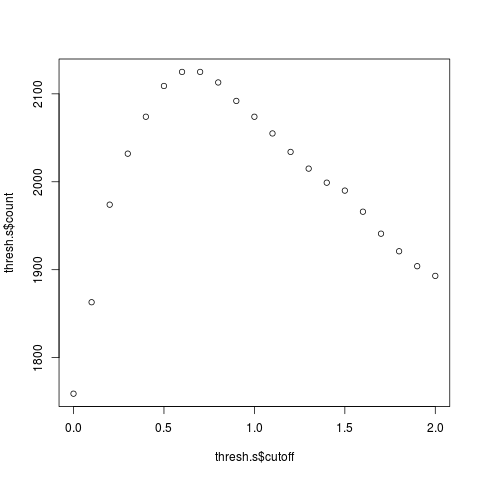

In [14]:
%%R
plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.6)

In [19]:
%%R
filter(DA,baseMean>=0.6) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../data/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [170]:
!head ../data/l2fc.csv | cut -c 1-80

"Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue","padj"
1,"1","OTU.43",223.480476760568,-0.110127792559516,0.290529241717165,0.704643875
1,"1","OTU.2",1664.01427323273,0.110952667246641,0.0783738103853471,0.1568676044
1,"1","OTU.187",362.132576964478,0.0660515941822755,0.159914812466415,0.67957556
1,"1","OTU.150",39.0567230436438,0.0320567063241244,0.158169528121542,0.83939056
1,"1","OTU.91",62.2114018390707,-0.0171831613331207,0.374974418838079,0.96344982
1,"1","OTU.305",37.7072580260407,-0.146295170832724,0.271030375040768,0.58935284
1,"1","OTU.25",187.19887275687,0.0945287904788471,0.241875397098751,0.6959332006
1,"1","OTU.4258",216.80811533347,-0.0986802477067795,0.111800295183156,0.3774267
1,"1","OTU.453",49.5655884056922,-0.172410725872039,0.1511126220515,0.2538940912


In [171]:
!wc -l ../data/l2fc.csv

15233 ../data/l2fc.csv
